# Insert summary

In [3]:
from Bio import SeqIO
from pydna.readers import read
from Bio.Restriction import *
from pydna.genbankrecord import GenbankRecord
from pydna.dseq import Dseq
import pandas as pd
%load_ext rpy2.ipython

In [4]:
inserts = snakemake.input['insert_genbank']

In [5]:
def read_genbank_files(*args):
    records = []
    for each_file in args:
        records.append(GenbankRecord(read(str(each_file))))
    return records

In [6]:
insert_records = read_genbank_files(*inserts)

## Insert sequence lengths

In [7]:
def clean_string(s):
    # remove junk from strings (underscores newlines etc)
    if s.count('_') == len(s) - 1 - s.count('_'):
        s = s.replace('_', '')
    return s.replace('_', ' ').strip()

In [8]:
def clean_insert_name(name):
    return name.split('_')[-1]

In [9]:
def ordered_feature_names(record):
    # get feature names in the order they appear in a record
    names = []
    for each_feature in sorted(record.features, key=lambda f: int(f.location.start)):
        names.append(clean_string(each_feature.extract(record).name))
    return names

In [10]:
def ordered_insert_names(names):
    # get insert names ordered by their number
    return sorted(names, key=lambda n: int(n.split('-')[-1]))

Add restriction sites as features.

In [11]:
def add_restriction_site_as_feature(record, enzyme):
    site_start = record.seq.watson.find(enzyme.site)  # using cut or casting GenbankRecord to string caused AttributeError. Bug?
    if site_start != -1:
        record.add_feature(site_start-1, site_start+len(enzyme.site)-1, label=str(enzyme))
    return record

In [12]:
cutters = [KpnI, HindIII, SacI, EcoRI]
def add_restriction_features(records, cutters):
    for i, each_record in enumerate(records):
        for each_cutter in cutters:
            records[i] = add_restriction_site_as_feature(each_record, each_cutter)
    return records

insert_records = add_restriction_features(insert_records, cutters)

Create dataframe of each insert's features and their lengths for plotting with ggplot.

In [13]:
def seq_len_df(records):
    df_rows = []
    for each_record in records:
        for each_feature in each_record.features:
            df_rows.append(
                {
                    'insert': clean_insert_name(each_record.name),
                    'feature': clean_string(each_feature.extract(each_record).name),
                    'feature_length': len(each_feature.extract(each_record))
                }
            )
    return pd.DataFrame(df_rows)

In [14]:
len_df = seq_len_df(insert_records)

In [15]:
feat_order = ordered_feature_names(insert_records[0])
insert_order = ordered_insert_names([clean_insert_name(r.name) for r in insert_records])
feat_order

['5 prime HR',
 'SacI',
 'KpnI',
 'Anchor region',
 'Variable region',
 'EcoRI',
 '3 prime HR']

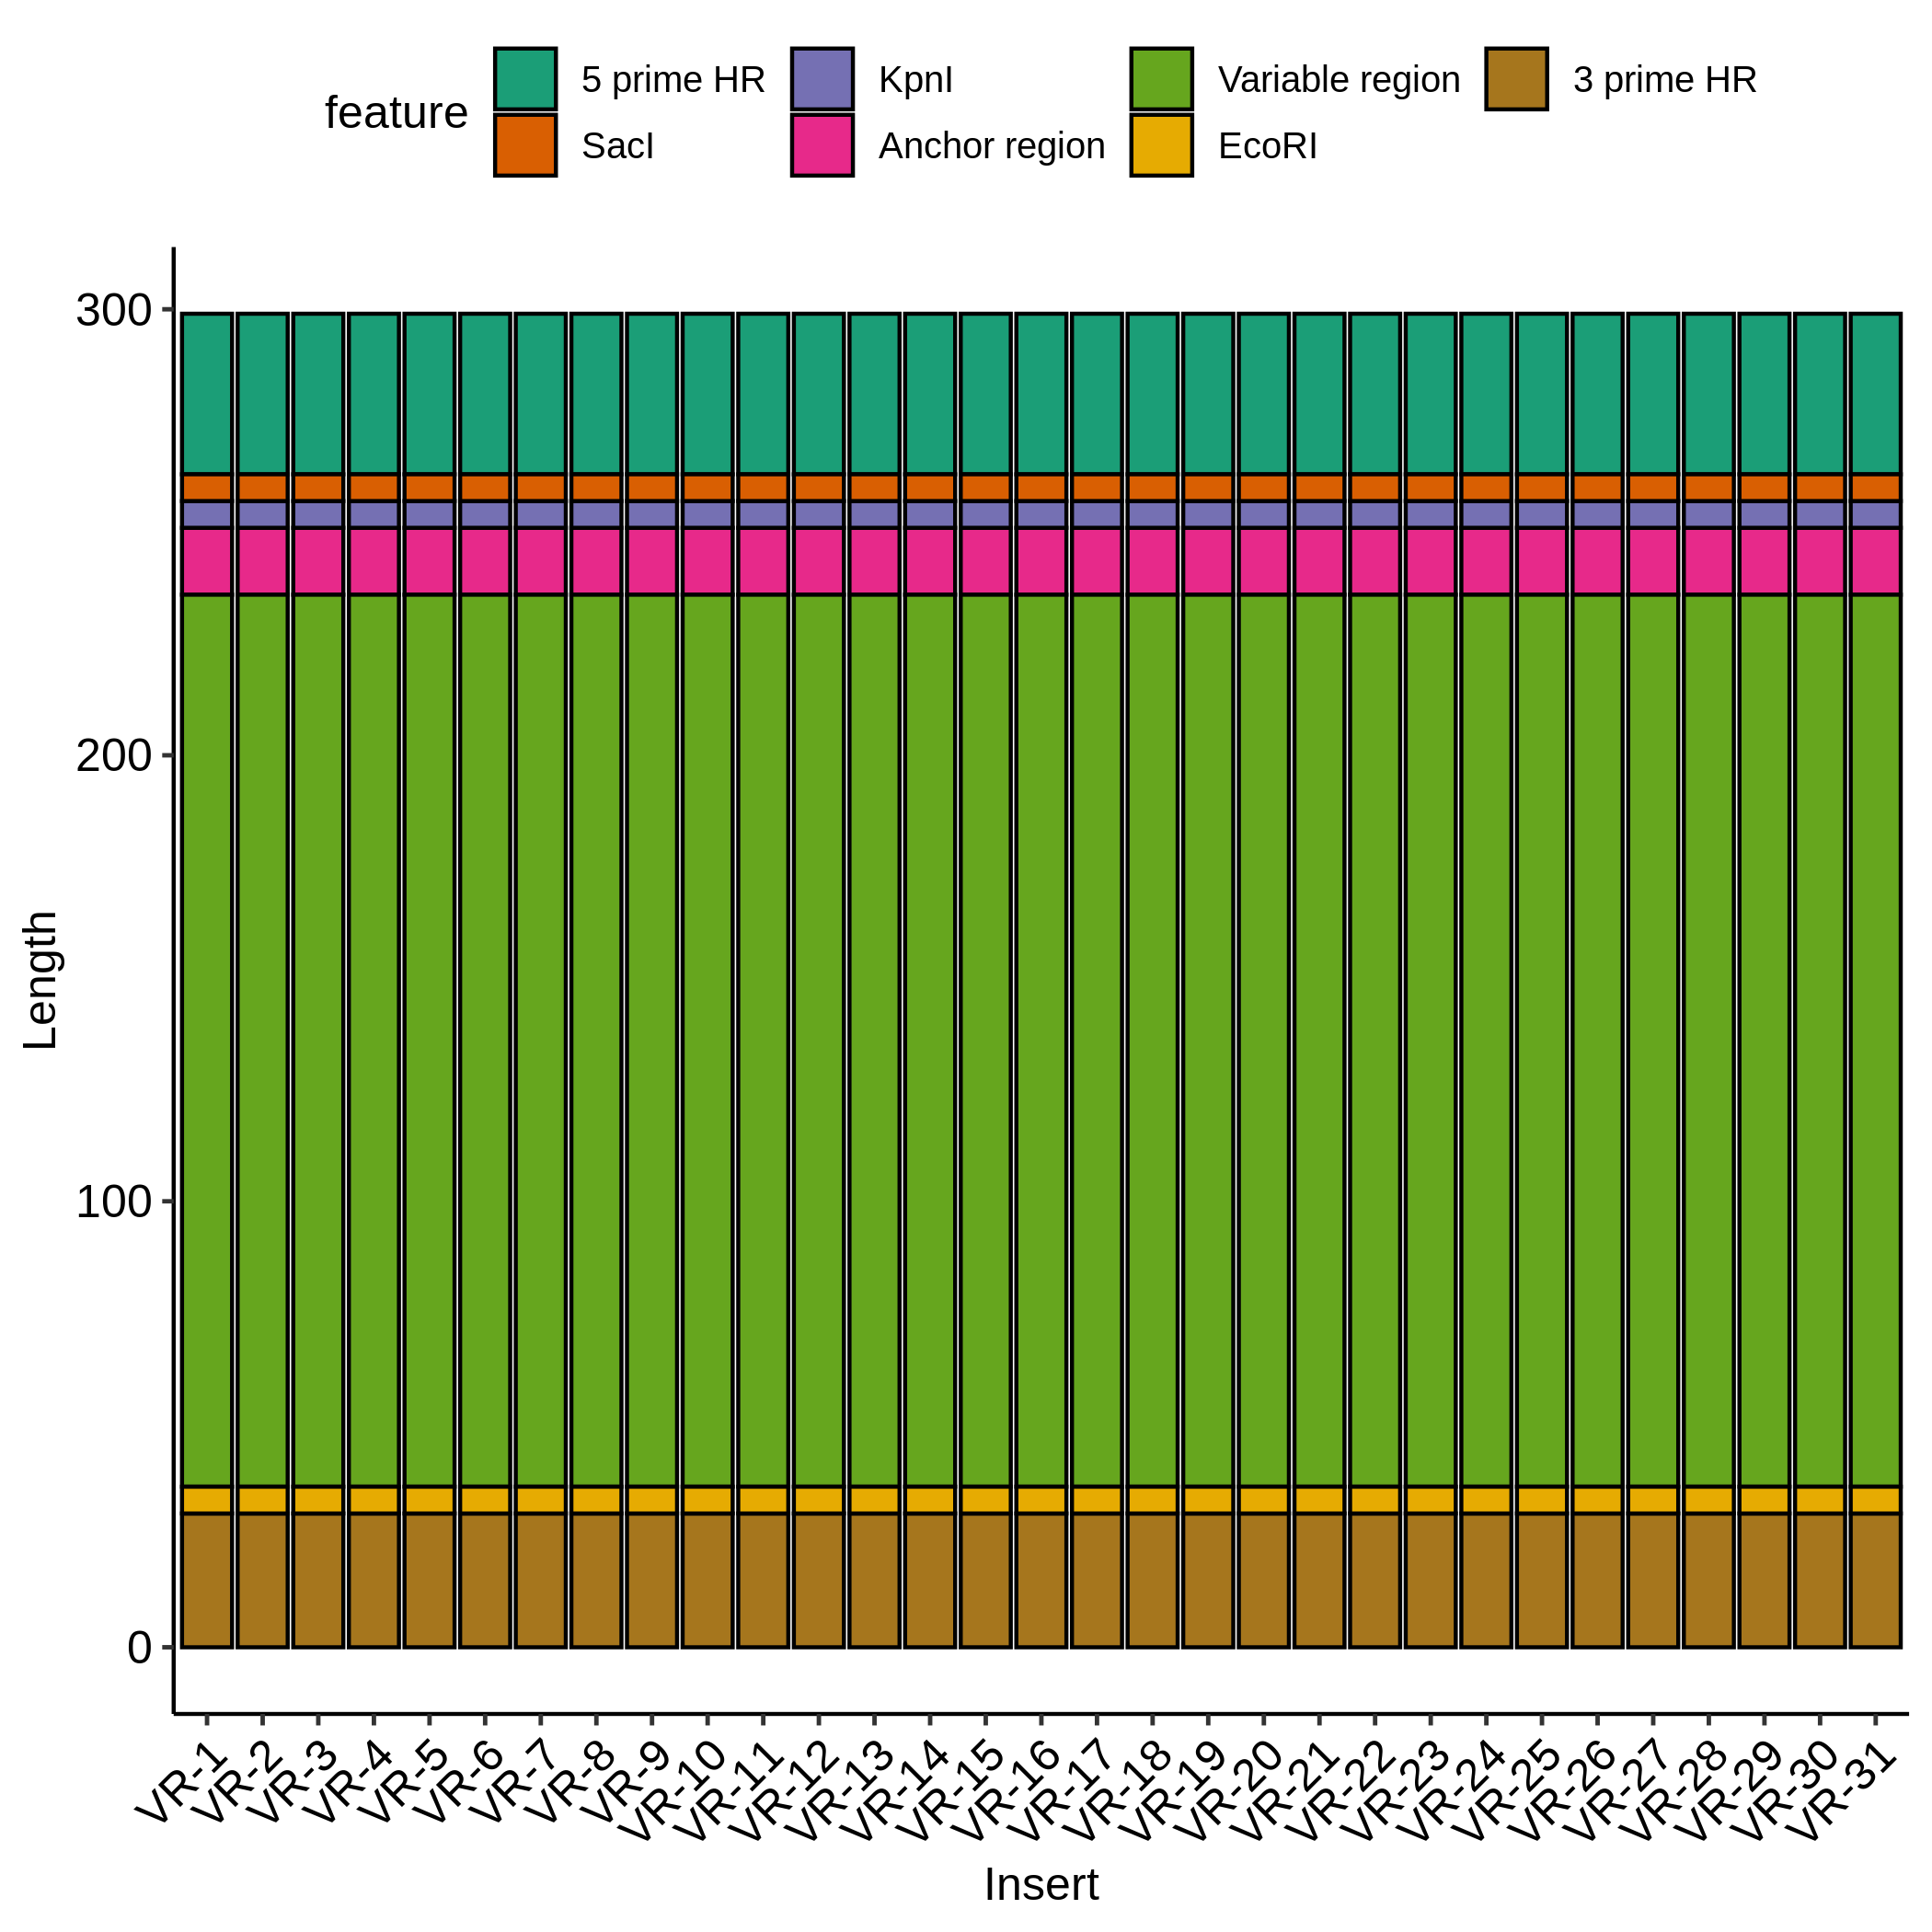

In [16]:
%%R -i len_df -i feat_order -i insert_order -w 7 -h 7 --units in -r 300
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
len_df$feature <- factor(len_df$feature, levels=feat_order)
len_df$insert <- factor(len_df$insert, levels=insert_order)
library(ggplot2)
library(ggpubr)
ggplot(len_df, aes(fill=feature, x=insert, y=feature_length)) + 
       geom_bar(position='stack', stat='identity', color='black') + labs(x='Insert', y='Length') +
        theme_pubr() + scale_fill_brewer(palette = "Dark2") +
        theme(axis.text.x = element_text(angle = 45, hjust=1))

Lengths of all feature types should be the same.

## GC content, skew and clustering

Functions for calculating GC skew and content.

In [17]:
def _gc_counts(seq):
    # helper function to get g c nuc counts from string
    seq_upper = seq.upper()
    return seq_upper.count('G'), seq_upper.count('C')

def _at_counts(seq):
    # helper function to get a t nuc counts from string
    seq_upper = seq.upper()
    return seq_upper.count('A'), seq_upper.count('T')

def GC_skew(seq):
    seq_g, seq_c = _gc_counts(seq)
    try:
        return (seq_g - seq_c) / (seq_g + seq_c)
    except ZeroDivisionError as e:
        return 0

def AT_skew(seq):
    seq_a, seq_t = _at_counts(seq)
    return (seq_a - seq_t) / (seq_a + seq_t)

def GC_content(seq):
    seq_g, seq_c = _gc_counts(seq)
    return (seq_g+seq_c) / len(seq)

def variable_region_seq_attributes(insert_record):
    vr = insert_record.extract_feature(2)
    return {'GC_Skew': GC_skew(vr.seq),
            'GC_Content': GC_content(vr.seq),
            'AT_Skew': AT_skew(vr.seq)
           }

### GC skew vs content dot plot

Shows the range of sequence attributes being tested.

In [18]:
gc_skew_content = []
for each_insert in insert_records:
    insert_skew_content = variable_region_seq_attributes(each_insert)
    insert_skew_content['name'] = each_insert.name
    gc_skew_content.append(insert_skew_content)
gc_skew_content_df = pd.DataFrame(gc_skew_content)

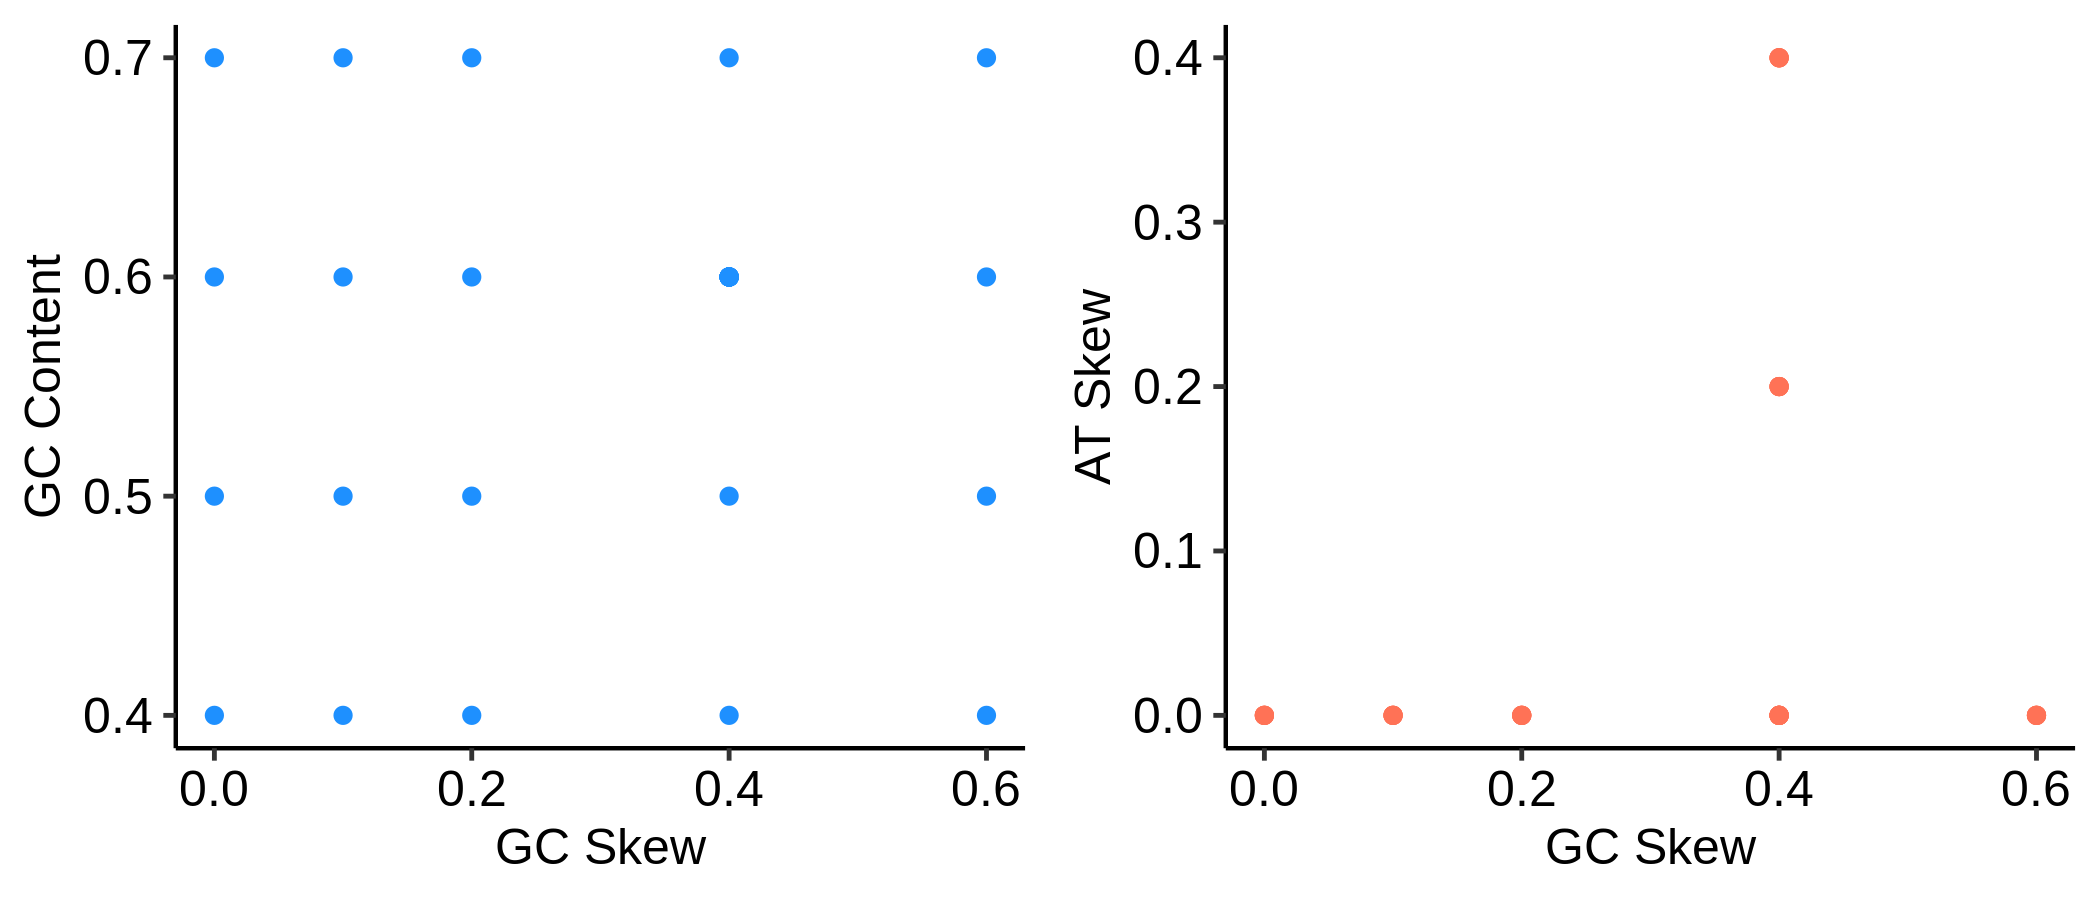

In [19]:
%%R -i gc_skew_content_df -w 7 -h 3 --units in -r 300
gc_skew_content <- ggplot(gc_skew_content_df, aes(x=GC_Skew, y=GC_Content)) + 
        geom_point(color='dodgerblue') + 
        theme_pubr() + labs(x='GC Skew', y='GC Content')

at_gc_skew <- ggplot(gc_skew_content_df, aes(x=GC_Skew, y=AT_Skew)) + 
        geom_point(color='coral1') + 
        theme_pubr() + labs(x='GC Skew', y='AT Skew')

ggarrange(gc_skew_content, at_gc_skew)

## GC skew content windows

In [20]:
def sliding_window_metric(insert, metric_func, window_size=40):
    seq = insert.extract_feature(2).seq
    window_metrics = []
    for window_end in range(window_size, len(seq), 10):
        window_start = window_end - window_size
        window = seq[window_start:window_end]
        metric_value = metric_func(window)
        window_metrics.append(
            {
                'window_start': window_start,
                'metric': metric_func.__name__.replace('_', ' '),
                'value': metric_value,
                'insert': insert.name,
                'value_full': metric_func(seq)
            }
        
        )
    return window_metrics

In [21]:
def sliding_window_all_inserts(insert_records, metric_func):
    table = []
    for each_insert in insert_records:
        values = sliding_window_metric(each_insert, metric_func)
        table += values
    return pd.DataFrame(table)

In [22]:
gc_skew_windows = sliding_window_all_inserts(insert_records, GC_skew)
gc_content_windows = sliding_window_all_inserts(insert_records, GC_content)
at_skew_windows = sliding_window_all_inserts(insert_records, AT_skew)

Function for plotting sliding window metrics binned over metric value for the complete sequence.

In [23]:
%%R -i gc_skew_windows -w 7 -h 7 --units in -r 300

library(RColorBrewer)

plot_windows <- function(windows.df){
    
    nb.cols <- length(unique(windows.df$insert))
    mycolors <- colorRampPalette(brewer.pal(8, "Dark2"))(nb.cols)
    
    metric_name <- unique(windows.df$metric)
    ggplot(windows.df, aes(x=window_start, y=value, color=insert)) +
    geom_point() + geom_line() + theme_pubr() + facet_wrap(~value_full) +
    labs(y=metric_name, x='Position') +
    scale_color_manual(values = mycolors) +
    theme(legend.position = "bnone") + 
    theme(
        axis.title.x = element_text(size=14, face="bold"),
        axis.title.y = element_text(size=14, face="bold")
    )
    
}

### GC skew over 40 bp windows binned by GC skew of the complete variable region

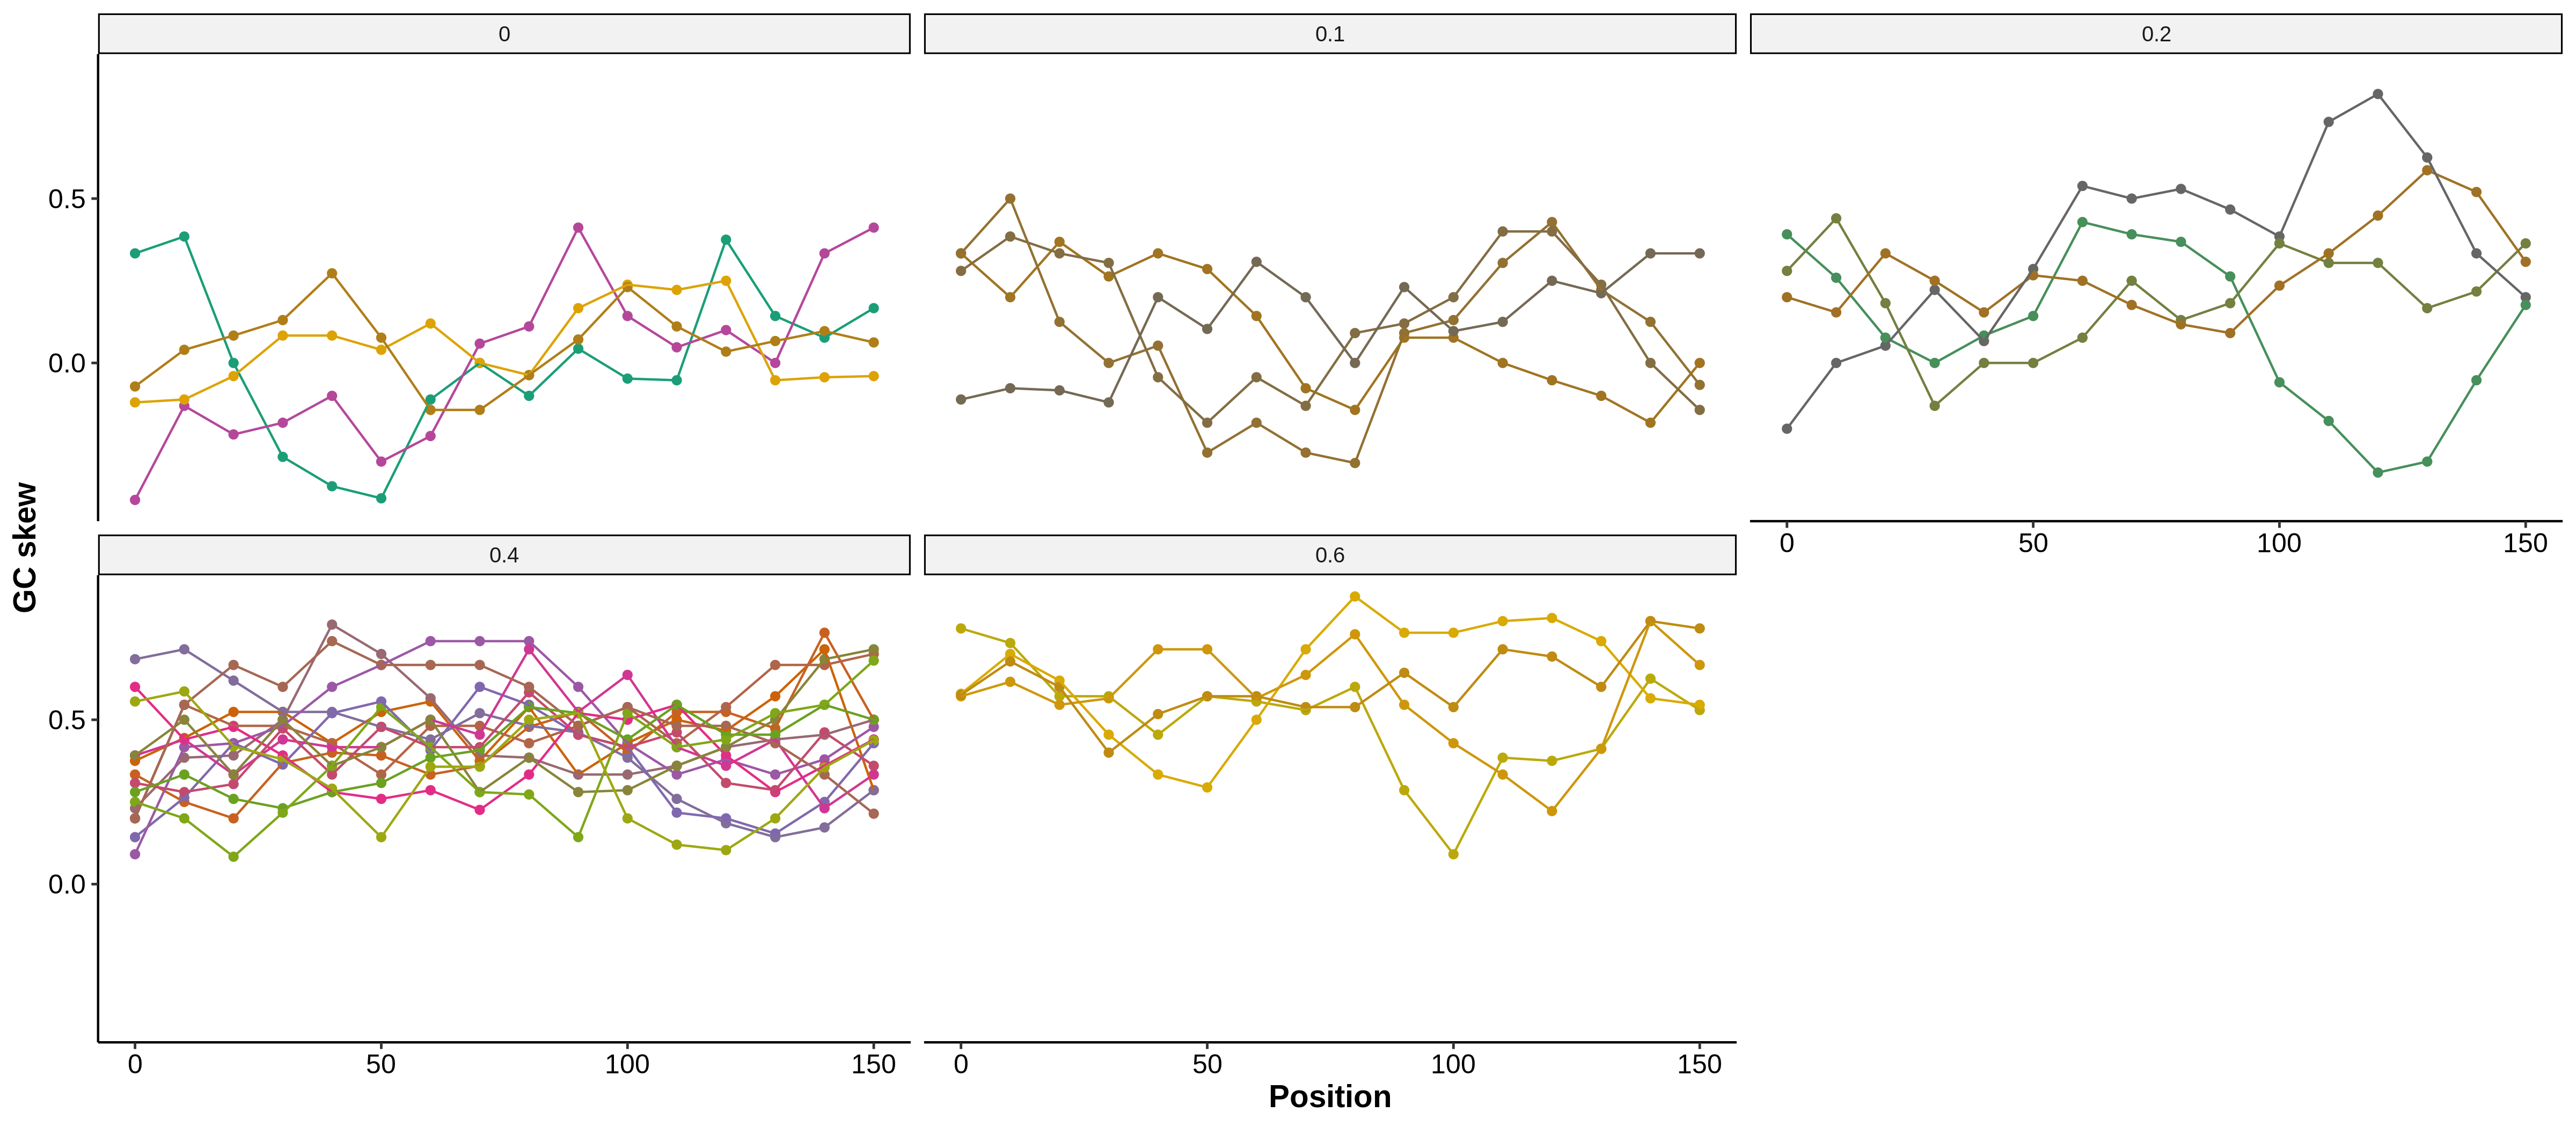

In [24]:
%%R -i gc_content_windows -w 16 -h 7 --units in -r 300
gc_skew <- plot_windows(gc_skew_windows)
gc_skew

### GC content over 40 bp windows binned by GC skew of the complete variable region

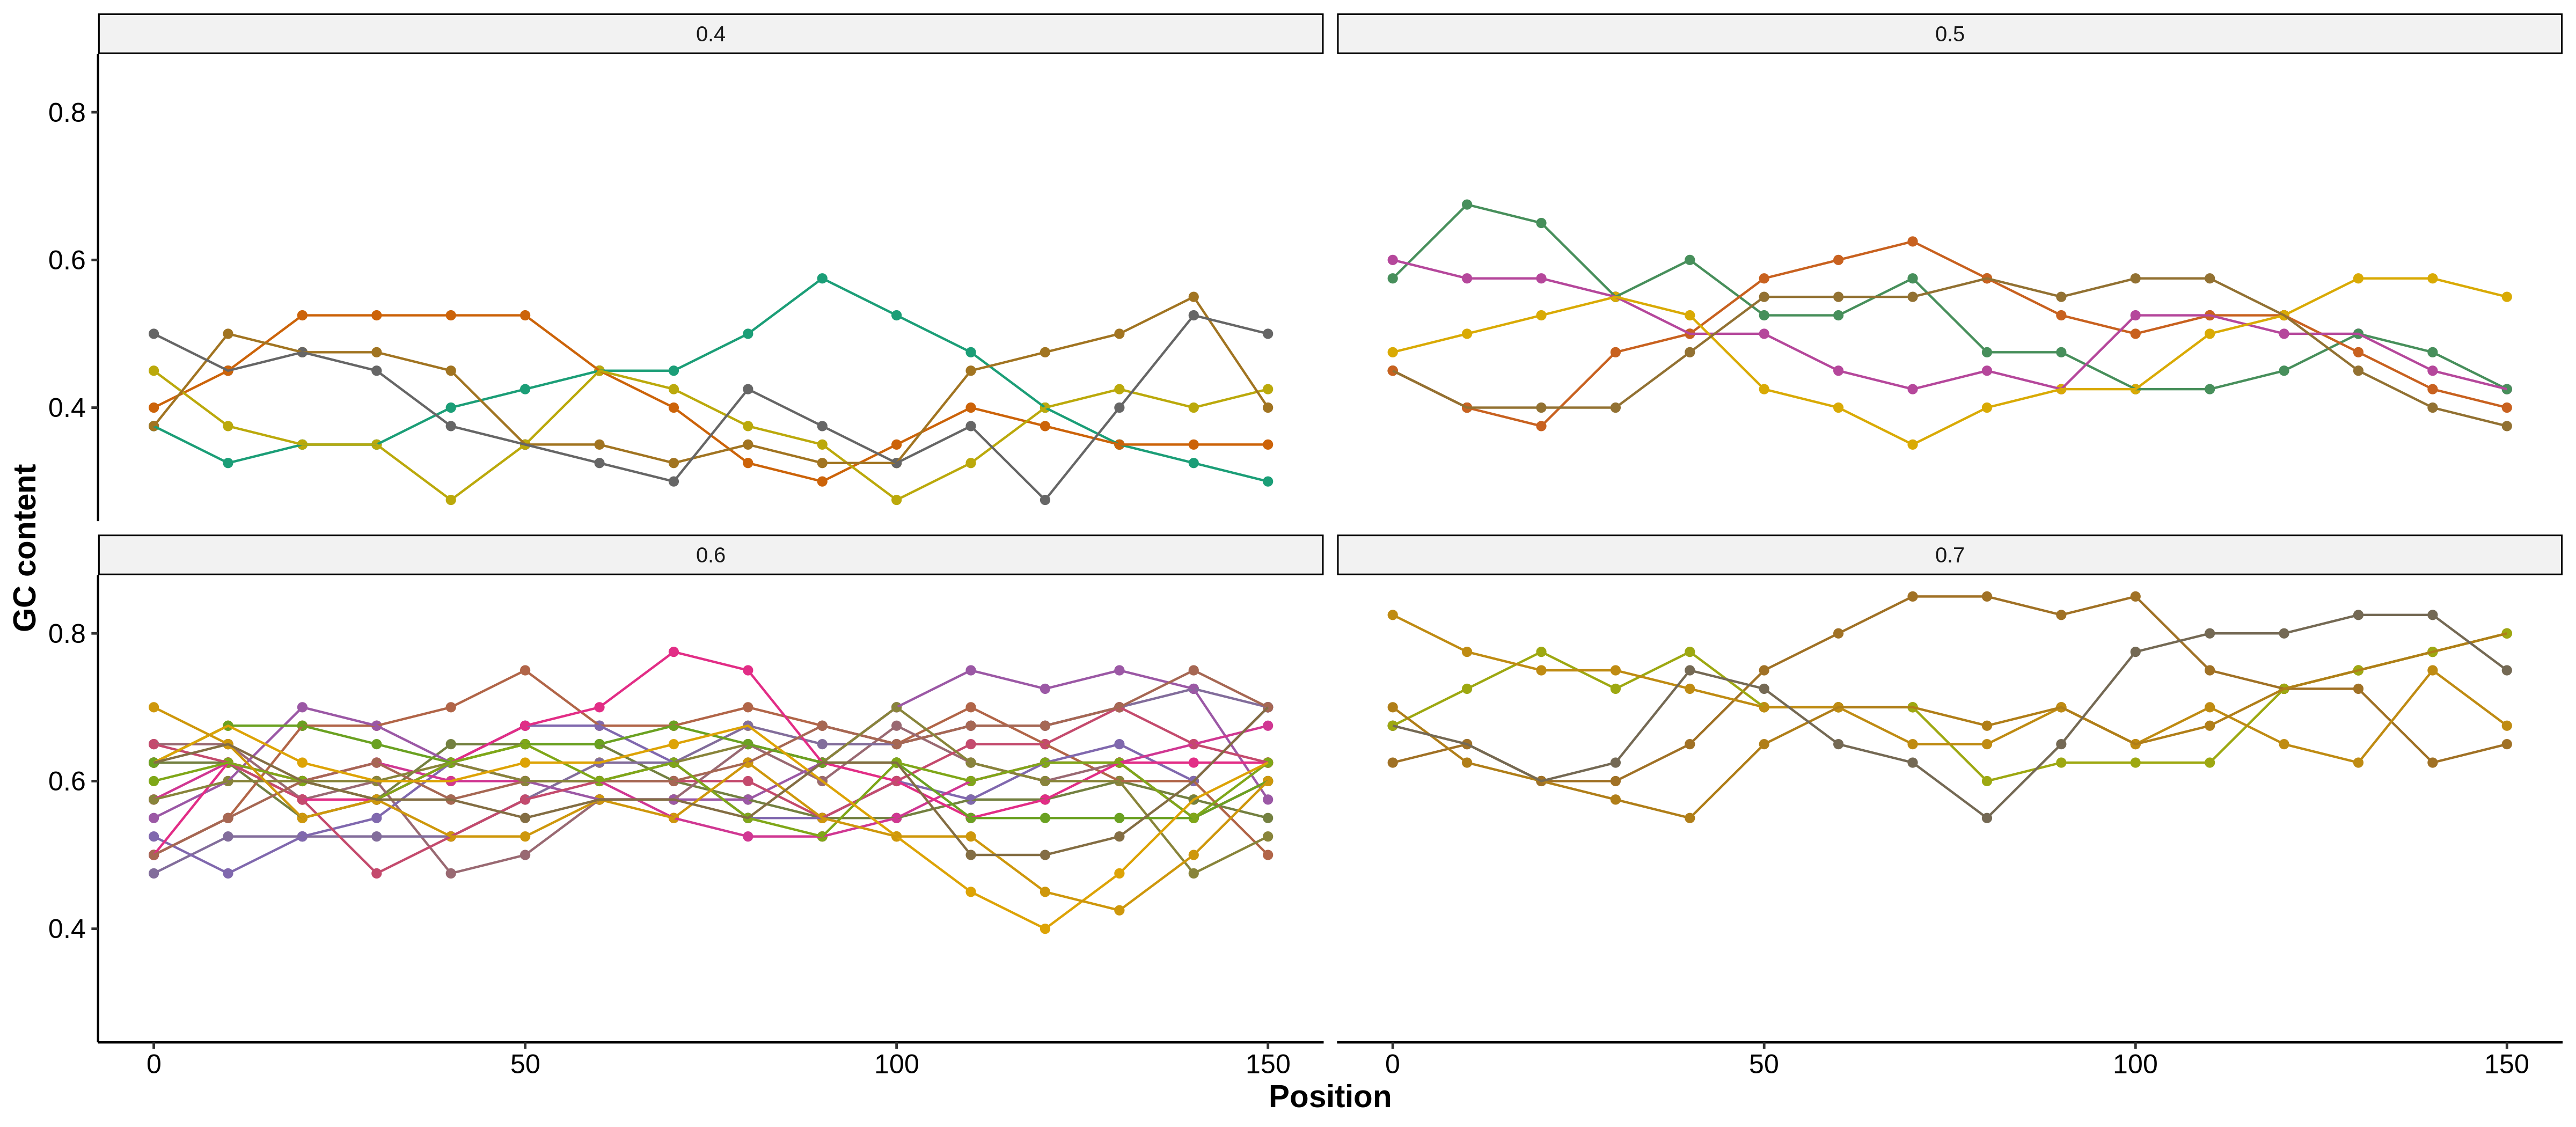

In [25]:
%%R -i gc_content_windows -w 16 -h 7 --units in -r 300
gc_content <- plot_windows(gc_content_windows)
gc_content

### AT content over 40 bp windows binned by GC skew of the complete variable region

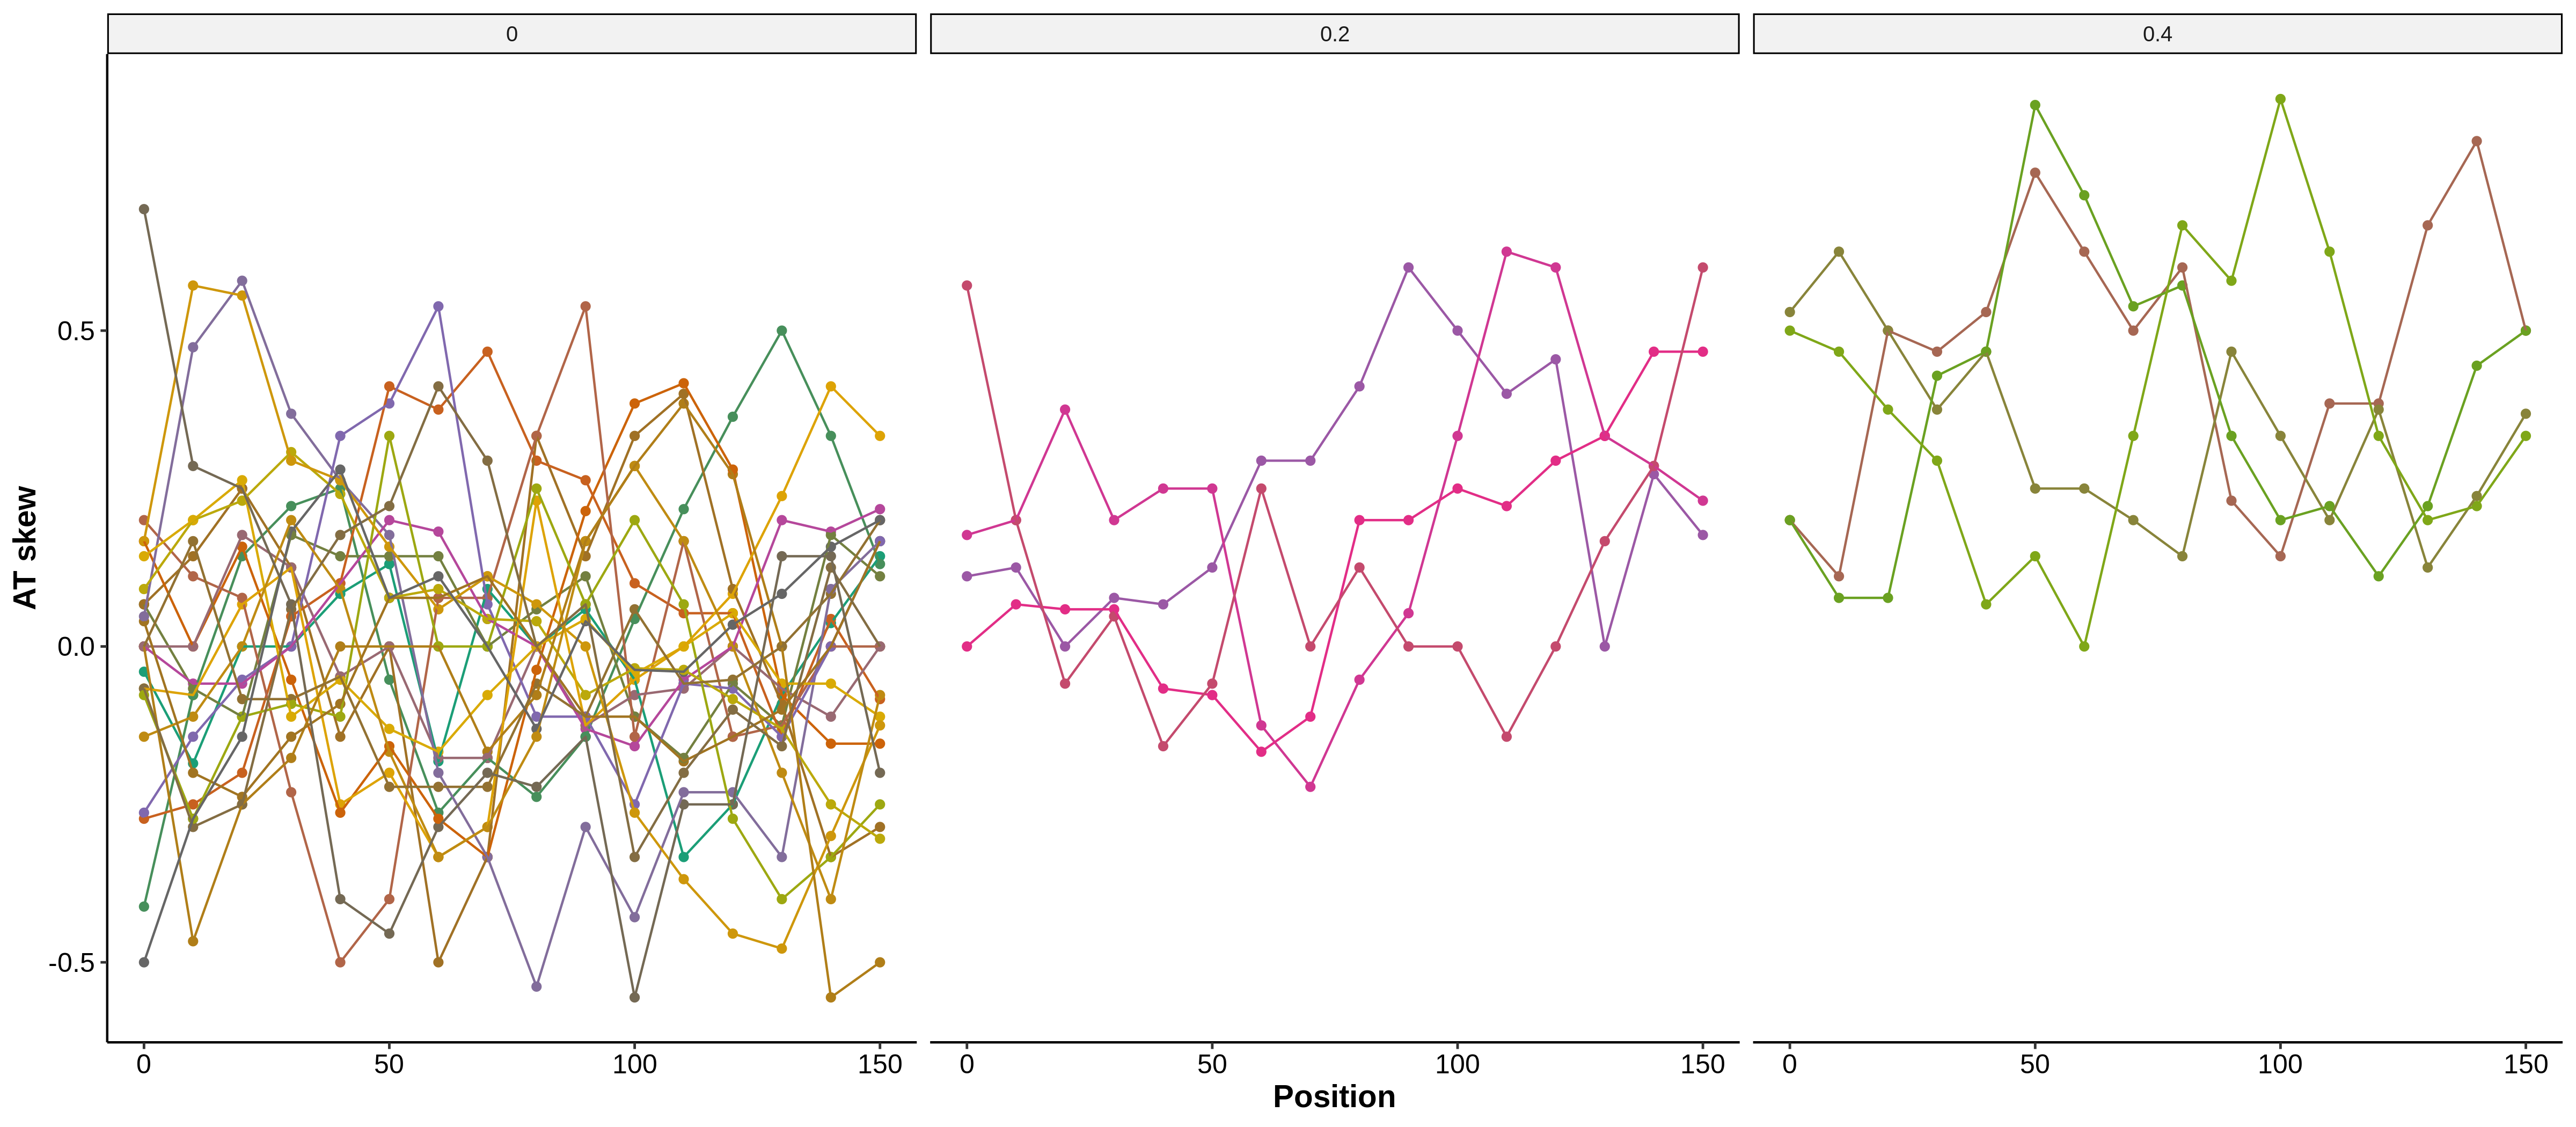

In [26]:
%%R -i at_skew_windows -w 16 -h 7 --units in -r 300
at_skew <- plot_windows(at_skew_windows)
at_skew

All three plots combined

In [30]:
#attributes = snakemake.output['insert_attributes']

AttributeError: 'OutputFiles' object has no attribute 'insert_attributes'

In [29]:
#snakemake.output

['output/insert_sequences_100_v2/inserts/insert_summary.txt']

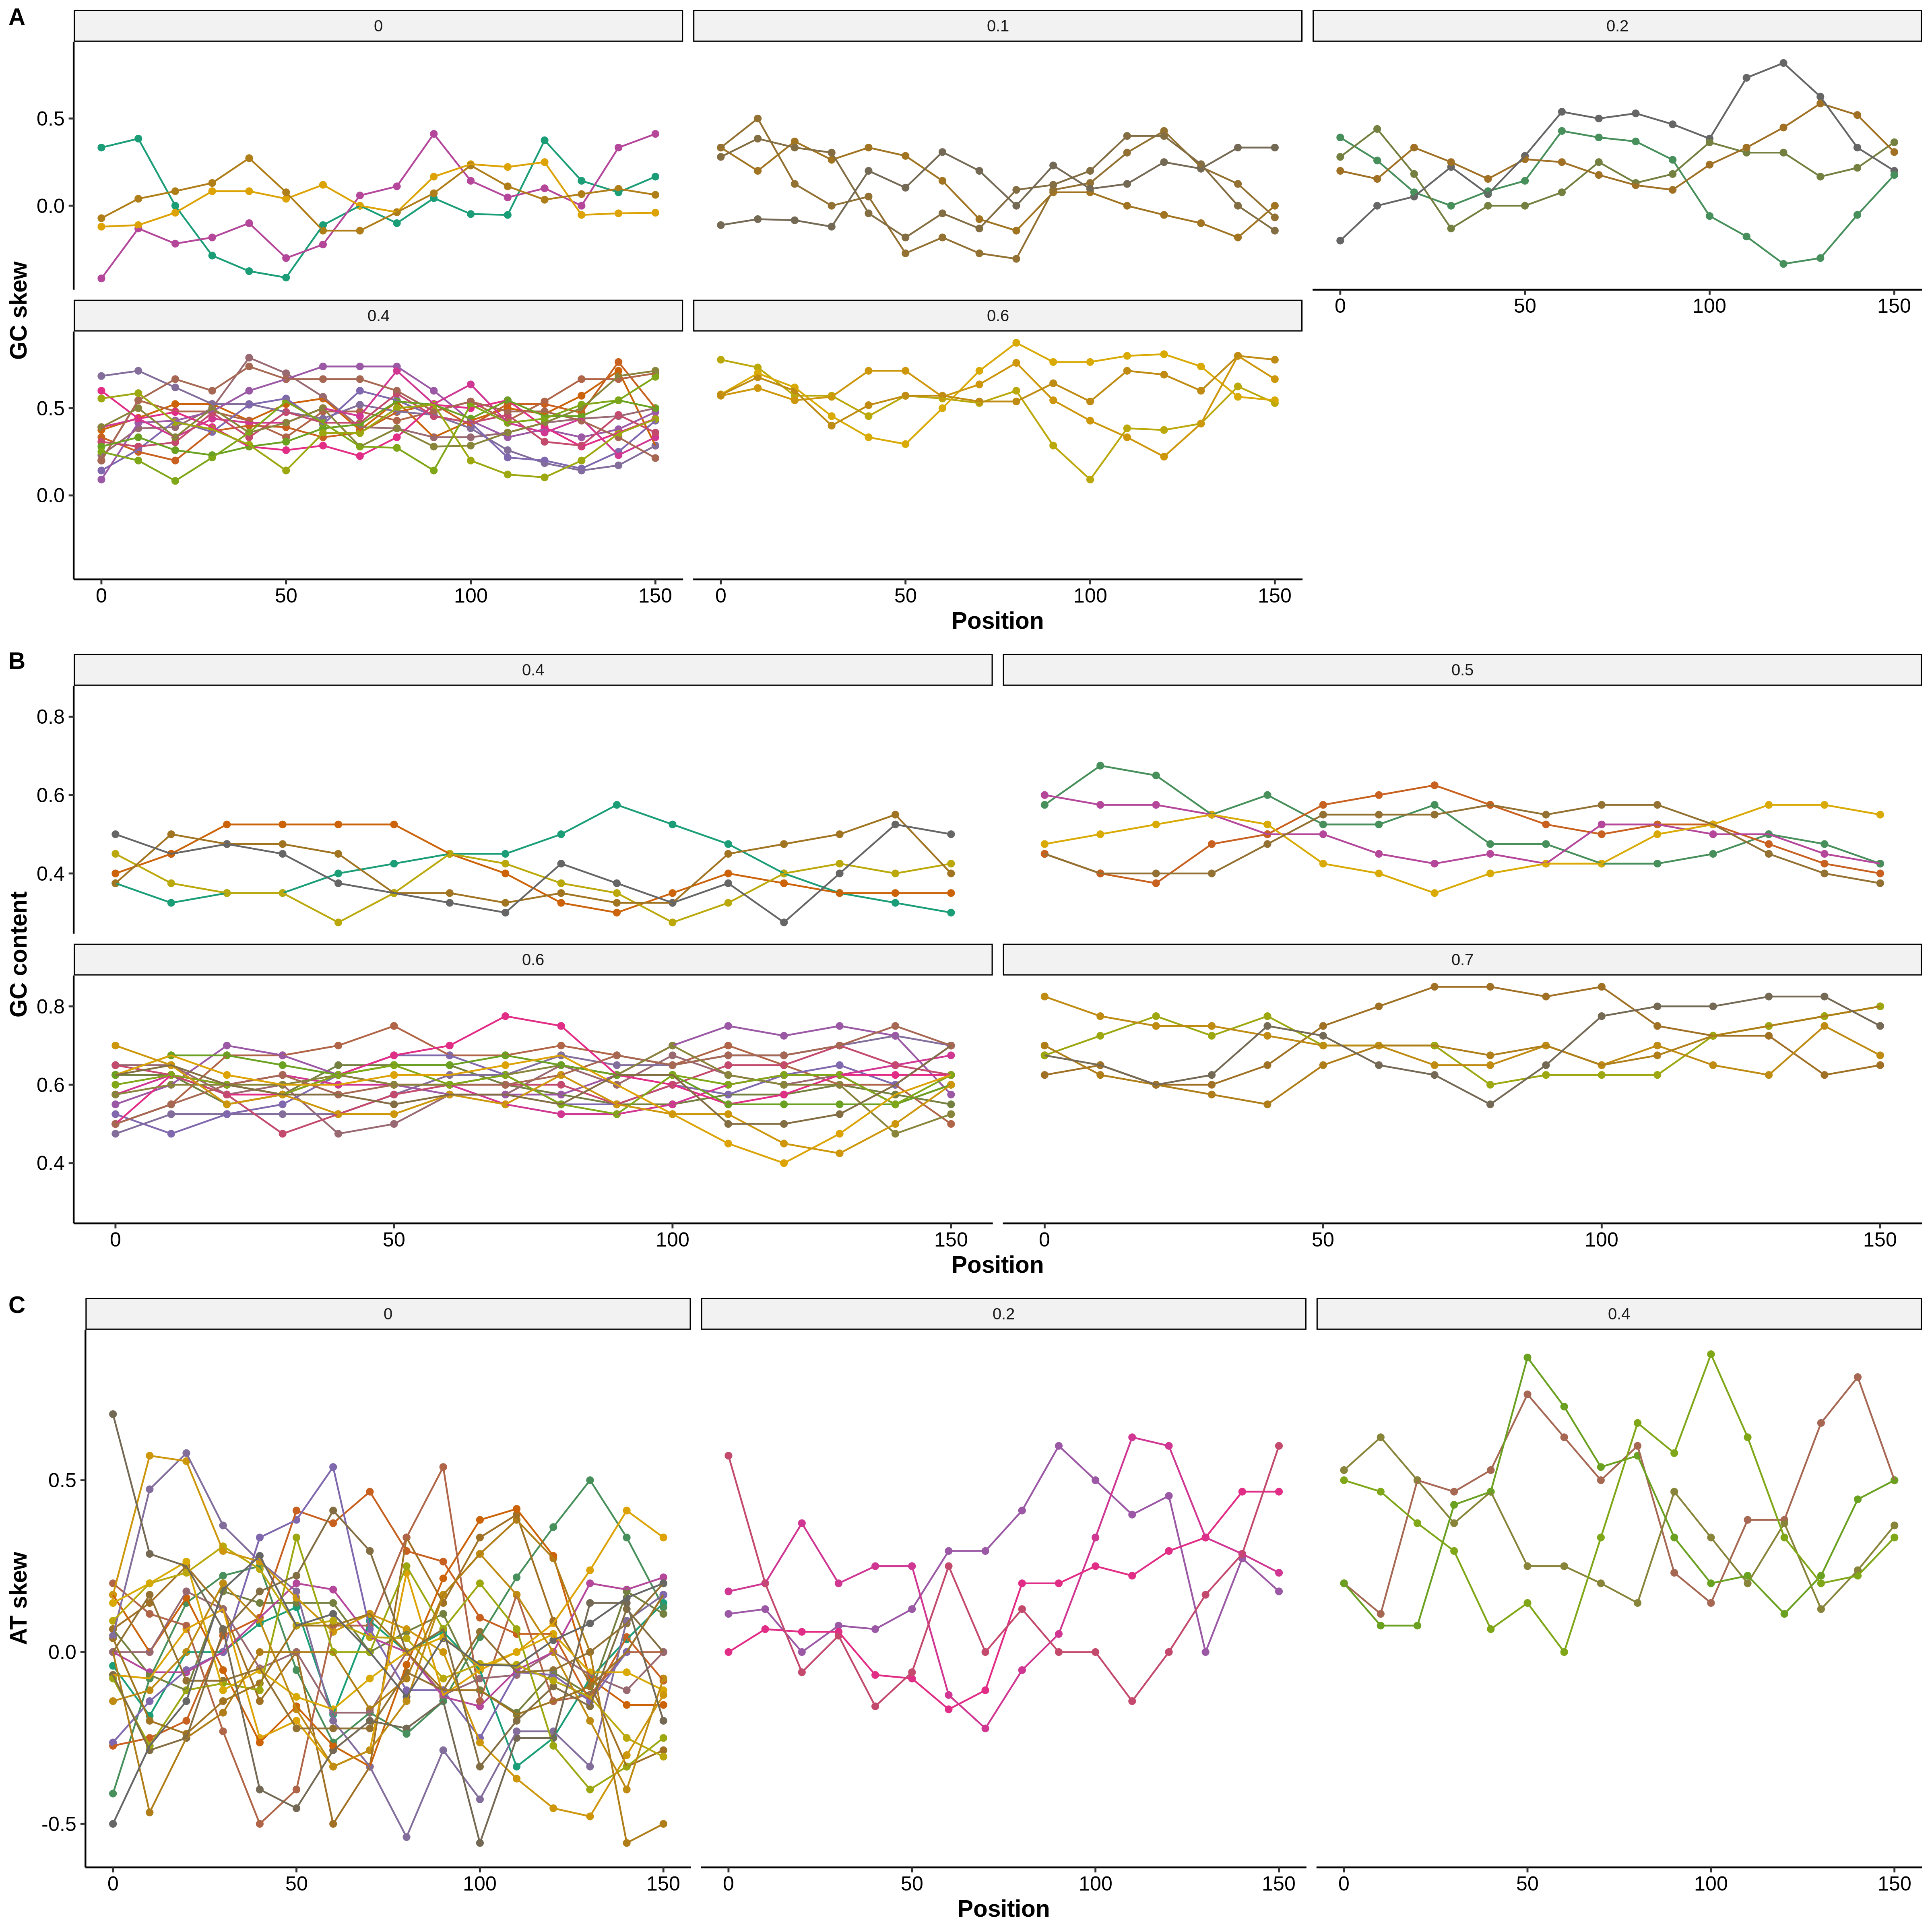

In [32]:
%%R -w 16 -h 16 --units in -r 300
attributes.plot <- ggarrange(gc_skew, gc_content, at_skew, nrow=3, ncol=1, labels=c('A', 'B', 'C'))
#ggsave(unlist(attributes), attributes.plot, height=16 width=16, unit='in', dpi=300)
#attributes.plot
attributes.plot

## G clustering

In [ ]:
def closest_nucleotide(seq, position, target_nuc):
    # finds the closest target nucleotide to a given position in a sequence.
    # Searches in both directions of a linear sequence.
    distance = 1
    found = False
    seq_upper = str(seq).upper()
    nuc_upper = target_nuc.upper()
    while not found:
        right_pos = position-distance
        left_pos = position+distance
        if right_pos >= 0 and right_pos < len(seq_upper) and seq_upper[right_pos] == nuc_upper:
            found = True
        if left_pos < len(seq_upper) and seq_upper[left_pos] == nuc_upper:
            found = True
        distance += 1
            
    return distance

def closest_nuc_across_seq(insert, target_nuc='G'):
    table = []
    vr_seq= insert.extract_feature(2).seq
    for i in range(len(vr_seq)):
        table.append(
            {
                'insert': clean_insert_name(insert.name),
                'position': i + 1,
                'distance': closest_nucleotide(vr_seq, i, target_nuc),
                'target_nuc': target_nuc
            }
        )
    # add mean distance rounded to closest integer
    mean_dist_int = int(sum([i['distance'] for i in table]) / len(table))
    [i.update({'mean_dist': mean_dist_int}) for i in table]
    
    return table


def closest_nuc_across_all_inserts(insert_records, target_nuc='G'):
    cluster_table = []
    for each_insert in insert_records:
        cluster_table += closest_nuc_across_seq(each_insert, target_nuc)
    return pd.DataFrame(cluster_table)
cluster_table = closest_nuc_across_all_inserts(insert_records)

In [ ]:
cluster_table

In [34]:
%%R -w 7 -h 7 --units in -r 300

library(RColorBrewer)

plot_cluster_dists <- function(cluster.df, insert.order){
    
    cluster.df$insert <- factor(cluster.df$insert, levels=insert.order)
    
    nb.cols <- length(unique(cluster.df$insert))
    mycolors <- colorRampPalette(brewer.pal(8, "Dark2"))(nb.cols)
    
    cluster_nuc <- unique(cluster.df$target_nuc)
    ggplot(cluster.df, aes(x=position, y=distance, color=insert)) +
    geom_point(size=0.2) + geom_line(size=0.2) + theme_pubr() +
    labs(y=paste('Distance to closest', cluster_nuc), x='Position') +
    scale_color_manual(values = mycolors) +
    theme(legend.position = "bnone") + 
    theme(
        axis.title.x = element_text(size=14, face="bold"),
        axis.title.y = element_text(size=14, face="bold")
    ) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    
}

plot_cluster_dists_wrap_mean <- function(cluster.df, insert.order){
    
   plot_cluster_dists(cluster.df, insert.order) + facet_wrap(~mean_dist)
    
}

plot_cluster_dist_wrap_insert <- function(cluster.df, insert.order){
    
    plot_cluster_dists(cluster.df, insert.order) + facet_wrap(~insert)
}

In [ ]:
#g_cluster_plot = snakemake.output['insert_G_clustering']

### Distance from each nucleotide to closest gaunine for all insert variable regions

In [33]:
%%R -i cluster_table -w 10 -h 7 --units in -r 300

g_clusters <- plot_cluster_dist_wrap_insert(cluster_table)
#ggsave(unlist(g_cluster_plot), g_clusters)
g_clusters

NameError: name 'cluster_table' is not defined